In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import functions as ff
#import newfunctions as nff
#import functionsDt1 as dff

from darts import TimeSeries as ts 
from darts import concatenate

from sklearn.metrics import mean_absolute_error,r2_score

from scipy.stats import friedmanchisquare

import scikit_posthocs as sp

import pickle
import warnings
warnings.filterwarnings("ignore")

#working from py file results in error due to tsfresh extract_features so we make pipeline in notebook
#to reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import os
fileList = os.listdir();
fileList = [i for i in fileList if ('.csv' in i)&('results' in i)&('ensemble' not in i)]; fileList

['results_4wPmean20x30.csv',
 'results_const020x30.csv',
 'results_constA20x30.csv',
 'results_constM20x30.csv',
 'results_DT20x30_Sel_rollingFalse.csv',
 'results_DT20x30_Sel_rollingTrue.csv',
 'results_DT20x30_TSFresh_rollingFalse.csv',
 'results_DT20x30_TSFresh_rollingTrue.csv',
 'results_DT20x30_uku_rollingFalse.csv',
 'results_DT20x30_uku_rollingTrue.csv',
 'results_GB20x30_kristjan_rollingFalse_ValFalse.csv',
 'results_GB20x30_kristjan_rollingFalse_ValTrue.csv',
 'results_GB20x30_kristjan_rollingTrue_ValFalse.csv',
 'results_GB20x30_kristjan_rollingTrue_ValTrue.csv',
 'results_GB20x30_Sel_rollingFalse_ValFalse.csv',
 'results_GB20x30_Sel_rollingFalse_ValTrue.csv',
 'results_GB20x30_Sel_rollingTrue_ValFalse.csv',
 'results_GB20x30_Sel_rollingTrue_ValTrue.csv',
 'results_GB20x30_TSFresh_rollingFalse_ValFalse.csv',
 'results_GB20x30_TSFresh_rollingFalse_ValTrue.csv',
 'results_GB20x30_TSFresh_rollingTrue_ValFalse.csv',
 'results_GB20x30_TSFresh_rollingTrue_ValTrue.csv',
 'results_GB

In [117]:
pd.read_csv(fileList[0])

,eic,moment,testMae,testR2,testWmape
0,B7B6B96D8CA1E97B16B47F51F58B6A6B,2021-12-21 23:00:00,0.963865,-3.925575,0.478019
1,B7B6B96D8CA1E97B16B47F51F58B6A6B,2021-07-10 05:00:00,0.764167,-16.652515,2.062760
2,B7B6B96D8CA1E97B16B47F51F58B6A6B,2021-04-11 16:00:00,0.510802,-1.193086,0.464032
3,B7B6B96D8CA1E97B16B47F51F58B6A6B,2021-06-02 03:00:00,1.285219,-2.895845,0.600429
4,B7B6B96D8CA1E97B16B47F51F58B6A6B,2021-06-08 01:00:00,0.581906,-1.864017,1.329059
...,...,...,...,...,...
775,B7B6B96D8CA1E97BC01543EF3267660A,2021-05-05 01:00:00,0.358021,-0.240425,0.713604
776,B7B6B96D8CA1E97BC01543EF3267660A,2021-11-08 01:00:00,0.255281,0.081632,0.721473
777,B7B6B96D8CA1E97BC01543EF3267660A,2021-10-16 16:00:00,0.144844,-0.569482,0.586907
778,B7B6B96D8CA1E97BC01543EF3267660A,2021-08-05 15:00:00,0.304125,-0.989363,0.855686


In [118]:
a ={}
af ={}
for filename in fileList:
    #d=pickle.load(open(filename, "rb"))
    d = pd.read_csv(filename)
    #cols = {i:d[i] for i in {i for i in d if 'params' not in i}}
    #algo = filename.split('maeCost_24x1_')[1].split('_len')[0]
    #algo = filename.split('maeCost_24x1_')[1].split('_len')[0]
    algo1,algo2,algo='','',''
    algo1 = filename.split('results_')[1].split('20x30')[0]
    
    if len(algo1) == 2: 
        algo1 = algo1.lower()
        algo1 = algo1 + ' 1m'
    
    try: algo2 = filename.split('20x30')[1].split('.csv')[0]
    except: algo2='sss'
    
    if 'fromData' in algo1: algo = algo1.split('.csv')[0].replace('fromData','').replace('.','')[:-1] 

    if len(algo2)==0: algo = algo1
    if 'rolling' in algo2:
        algo2 = algo2.replace('Sel','autofeat')
        algo2 = algo2.replace('TSFresh','tsfresh')
        algo2 = algo2.replace('Val','bestVal')
        algo2 = algo2.replace('True','T')
        algo2 = algo2.replace('False','F')
        algo2 = algo2.replace('bestValT','') #default dont show anything
        algo=algo1+'_'+algo2
    algo = algo.replace('_',' ')
    
    a[algo] = d.rename(columns={'testMae':'test MAE'})    
    af[algo] = filename

In [119]:
cols = ['test MAE','testR2','testWmape','eic','moment']

results = pd.DataFrame()
for df in a:
    dd = a[df][cols].set_index(['eic','moment']).rename(mapper = lambda x: x+': '+df, axis='columns')
    results = pd.concat([dd,results],axis=1)
results = results.dropna(axis=0)

In [120]:
results.isna().sum().sum()

0

In [121]:
results_mean = results.mean(axis=0).to_frame().T.assign(name='mean').set_index('name').rename_axis(None)
results_median = results.median(axis=0).to_frame().T.assign(name='median').set_index('name').rename_axis(None)
meanMedian = pd.concat([results_mean,results_median],axis=0)

H0 is rejected! Algorithms perform differently.  
Next we utilize post-hoc Nemenyi Test to find the best-performing algorithm. Nemenyi test compares algorithms pairwise and returns the p-values for each pairwise comparison of means. This can be used to find the groups of algos that differ after Friedman statistical test.

In [122]:
algos = [i for i in a]; 
algos

['4wPmean',
 'const0',
 'constA',
 'constM',
 'dt 1m  autofeat rollingF',
 'dt 1m  autofeat rollingT',
 'dt 1m  tsfresh rollingF',
 'dt 1m  tsfresh rollingT',
 'dt 1m  uku rollingF',
 'dt 1m  uku rollingT',
 'gb 1m  kristjan rollingF bestValF',
 'gb 1m  kristjan rollingF ',
 'gb 1m  kristjan rollingT bestValF',
 'gb 1m  kristjan rollingT ',
 'gb 1m  autofeat rollingF bestValF',
 'gb 1m  autofeat rollingF ',
 'gb 1m  autofeat rollingT bestValF',
 'gb 1m  autofeat rollingT ',
 'gb 1m  tsfresh rollingF bestValF',
 'gb 1m  tsfresh rollingF ',
 'gb 1m  tsfresh rollingT bestValF',
 'gb 1m  tsfresh rollingT ',
 'gb 1m  uku rollingF bestValF',
 'gb 1m  uku rollingF ',
 'gb 1m  uku rollingT bestValF',
 'gb 1m  uku rollingT ',
 'naive',
 'oracle']

This can be plotted as follows by finding average ranks of the algorithms and unifying algorithms by means of critical distance (critical distance plot)

In [126]:
def plotCD(data,algos,metric,size=12,left = 5,filename=None):
    plt.rcParams.update({'font.size': size})

    dd = data.rank(axis=1).mean(axis=0).sort_values() #data with sorted averaged ranks: larger rank means larger error
    meanRanks, methods = dd.values, dd.index.values
    methodsPure = [i.split(': ')[1] for i in methods]
    
    plt.axhline(0,c='k')
    for i in np.arange(int(meanRanks.min()),int(meanRanks.max())+2):
        plt.plot([i,i],[-0.05,0.05],c='k')
        plt.text(i-0.04,0.08,f'{i}')
    plt.ylim(-2.5,0.6)
    plt.axis('off')
    #plot data
    colors = ['r','g','b','y','c','m','y']
    colors += colors + colors + colors+colors+ colors+colors
    
    for i,r in enumerate(meanRanks):
        if i<left: #these algoes are named to left
            y = -0.3-i*0.15
            plt.plot([min(meanRanks)-0.2,r],[y,y],c=colors[i]) #vertical market
            plt.text(min(meanRanks)-0.2,y,f'{methodsPure[i]}', horizontalalignment='right',c=colors[i]) #shift x coordinate of text to avoid overlapping
        else: 
            y = -0.3-(len(meanRanks)-1-i)*0.15
            plt.plot([max(meanRanks)+0.2,r],[y,y],c=colors[i])
            plt.text(max(meanRanks)+0.2,y,f'{methodsPure[i]}', horizontalalignment='left',c=colors[i]) #shift x coordinate of text to avoid overlapping
        plt.plot([r,r],[0,y],c=colors[i]) #horizontal marker
#critical distance (CD) for Nemeyi test from https://kourentzes.com/forecasting/2014/05/01/critical-values-for-the-nemenyi-test/
    K = len(methods) #number of models
    N = data.shape[0] #number of measurements
    qdata = pd.read_csv('nemenyi.csv')
    q = qdata[qdata['# models']==K]['Nemenyi 0.05'].values[0]
    CD=q*np.sqrt(K*(K+1)/(6*N))  #number of models K=6, alpha=0.05
    x= np.mean(meanRanks)
    plt.plot([x,x+CD],[0.3,0.3],c='r',lw=3)
    plt.text(x,0.4,f'CD={CD:.3f}')
#plot pairwise pvalues
    pairwiseP = sp.posthoc_nemenyi_friedman(data.values)
    pairwiseP.columns, pairwiseP.index = data.columns, data.columns  #rename columns and index
    for m in methods:
        pvalues = pairwiseP[m]
        for mm in pvalues.index.values:
            if (pvalues[mm]>0.05)&(meanRanks[np.where(methods==m)[0][0]]!=meanRanks[np.where(methods==mm)[0][0]]):
                #print(m,mm,pvalues[mm])
                plt.plot([meanRanks[np.where(methods==m)[0][0]],meanRanks[np.where(methods==mm)[0][0]]],[-0.2,-0.2],c='k',lw=4)
    bestRank = data[[metric+': '+i for i in algos]].rank(axis=1).mean(axis=0).sort_values()[0]
    worstRank = data[[metric+': '+i for i in algos]].rank(axis=1).mean(axis=0).sort_values()[-1]
    plt.plot([bestRank,bestRank+CD],[-0.15,-0.15],c='r',lw=4)
    plt.plot([worstRank,worstRank-CD],[-0.25,-0.25],c='r',lw=4)
    plt.title(f'{metric[0].upper()+metric[1:]} mean rank and critical distance (CD)')
    if filename!=None: plt.savefig(f"{metric.replace(' ','_')}_cd"+filename+".eps", format='eps',dpi=200,bbox_inches='tight')
    return plt.show()

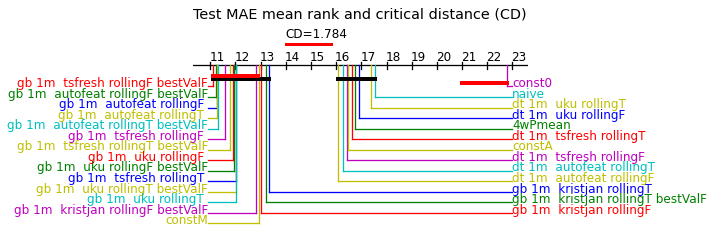

,test MAE: oracle,test MAE: gb 1m autofeat rollingF bestValF,test MAE: gb 1m autofeat rollingF,test MAE: gb 1m autofeat rollingT bestValF,test MAE: gb 1m autofeat rollingT,test MAE: gb 1m tsfresh rollingF bestValF,test MAE: gb 1m tsfresh rollingF,test MAE: gb 1m tsfresh rollingT bestValF,test MAE: gb 1m tsfresh rollingT,test MAE: constM,...,test MAE: naive,test MAE: dt 1m autofeat rollingF,test MAE: dt 1m autofeat rollingT,test MAE: dt 1m uku rollingF,test MAE: constA,test MAE: dt 1m tsfresh rollingT,test MAE: dt 1m uku rollingT,test MAE: dt 1m tsfresh rollingF,test MAE: 4wPmean,test MAE: const0
mean,0.0,0.180716,0.180799,0.181016,0.181324,0.182186,0.184524,0.184970,0.186008,0.196095,...,0.210791,0.217634,0.220523,0.220894,0.222831,0.223452,0.223892,0.223968,0.225661,0.330543
median,0.0,0.087864,0.087281,0.087605,0.086960,0.085409,0.085789,0.086961,0.086866,0.085792,...,0.117500,0.099266,0.104173,0.106611,0.096812,0.101309,0.103537,0.102248,0.112219,0.181833


In [127]:
metric = 'test MAE'
plotCD(results[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,left=14,filename='_EE')
meanMedian[[metric+': '+i for i in algos]].sort_values(by='mean',axis=1)

In [21]:
meanMedian[[metric+': '+i for i in algos]].columns

Index(['test MAE: 4wPmean', 'test MAE: const0', 'test MAE: constA',
       'test MAE: constM', 'test MAE: dt 1m  autosel rollingF',
       'test MAE: dt 1m  autosel rollingT',
       'test MAE: dt 1m  tsfresh rollingF',
       'test MAE: dt 1m  tsfresh rollingT', 'test MAE: dt 1m  uku rollingF',
       'test MAE: dt 1m  uku rollingT',
       'test MAE: gb 1m  kristjan rollingF bestValF',
       'test MAE: gb 1m  kristjan rollingF ',
       'test MAE: gb 1m  kristjan rollingT bestValF',
       'test MAE: gb 1m  kristjan rollingT ',
       'test MAE: gb 1m  autosel rollingF bestValF',
       'test MAE: gb 1m  autosel rollingF ',
       'test MAE: gb 1m  autosel rollingT bestValF',
       'test MAE: gb 1m  autosel rollingT ',
       'test MAE: gb 1m  tsfresh rollingF bestValF',
       'test MAE: gb 1m  tsfresh rollingF ',
       'test MAE: gb 1m  tsfresh rollingT bestValF',
       'test MAE: gb 1m  tsfresh rollingT ',
       'test MAE: gb 1m  uku rollingF bestValF',
       'test MAE: gb 1

In [26]:
meanMedian[[metric+': '+i for i in algos]][['test MAE: naive']]

,test MAE: naive
mean,0.210791
median,0.117500


In [128]:
eics = results.reset_index()['eic'].unique()

eicBestRank = {}
for e in eics:
    d = results.reset_index()
    d = d[d['eic']==e][[i for i in results.columns if 'MAE' in i]]
    d = d.rename(columns={i:i.split(': ')[1] for i in d.columns})
    eicBestRank[e] = d[[i for i in d.columns if 'oracle' not in i]].rank(axis=1).mean(axis=0).sort_values().index[0]

In [129]:
eicBestRank

{'B7B6B96D8CA1E97B001C70C0C9AE7D59': 'gb 1m  tsfresh rollingF bestValF',
 'B7B6B96D8CA1E97B01740297BA64E433': 'gb 1m  uku rollingT bestValF',
 'B7B6B96D8CA1E97B03DB654FA70CE1B8': 'gb 1m  autofeat rollingT ',
 'B7B6B96D8CA1E97B0A7628046D7E2ED3': 'constM',
 'B7B6B96D8CA1E97B16B47F51F58B6A6B': 'gb 1m  autofeat rollingF bestValF',
 'B7B6B96D8CA1E97B224851B9682C286C': 'constA',
 'B7B6B96D8CA1E97B29890582FC608BA9': 'gb 1m  tsfresh rollingF bestValF',
 'B7B6B96D8CA1E97B2DE94BA83BE04DB9': 'gb 1m  autofeat rollingF ',
 'B7B6B96D8CA1E97B308EC5153BD96044': 'constM',
 'B7B6B96D8CA1E97B4D51F3D61DFEA629': 'constM',
 'B7B6B96D8CA1E97B79C9F88B4BA82A59': 'gb 1m  tsfresh rollingF bestValF',
 'B7B6B96D8CA1E97B8551FBD1728BD900': 'gb 1m  autofeat rollingT bestValF',
 'B7B6B96D8CA1E97B9B44F2A15EFF2DF7': 'gb 1m  autofeat rollingT bestValF',
 'B7B6B96D8CA1E97B9D9DE3B0AC99E9CB': 'gb 1m  autofeat rollingF ',
 'B7B6B96D8CA1E97BB86AAB5DEBE89493': 'const0',
 'B7B6B96D8CA1E97BC01543EF3267660A': 'gb 1m  uku rollingF

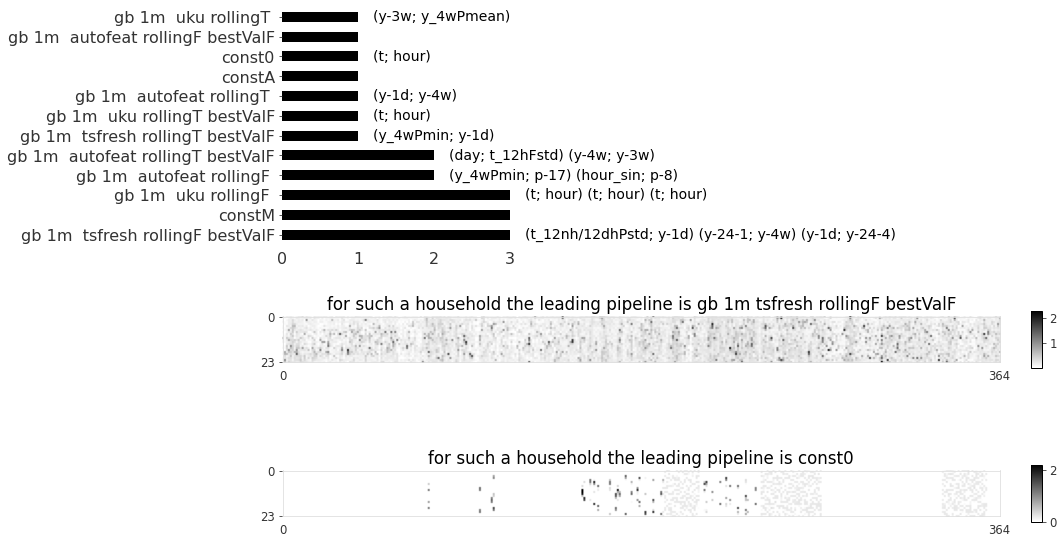

In [131]:
d0 =pd.read_csv('data/consumption_2021.csv')


plt.rcParams.update({'font.size': 14})

fig, (axs1,axs2,axs3) = plt.subplots(nrows=3, ncols=1,figsize=(15,8),gridspec_kw={'height_ratios': [2, 1,1]}) 
axs=(axs1,axs2,axs3)
ax=axs[0]

pd.DataFrame({'pipeline':list(eicBestRank.values())})['pipeline'].value_counts().plot(kind='barh',ax=ax,width=0.5,fontsize=16)
ax.set_xticks([0,1,2,3])
ax.set_xlim(0,10)
#ax.set_ylim(0,11)
ax.grid(False)
ax.text(3.2,-0.2,'(t_12nh/12dhPstd; y-1d) (y-24-1; y-4w) (y-1d; y-24-4)')
ax.text(3.2,1.8,'(t; hour) (t; hour) (t; hour)')
ax.text(2.2,2.8,'(y_4wPmin; p-17) (hour_sin; p-8)')
ax.text(2.2,3.8,'(day; t_12hFstd) (y-4w; y-3w)')
ax.text(1.2,4.8,'(y_4wPmin; y-1d)')
ax.text(1.2,5.8,'(t; hour)')
ax.text(1.2,6.8,'(y-1d; y-4w)')
ax.text(1.2,8.8,'(t; hour)')
ax.text(1.2,10.8,'(y-3w; y_4wPmean)')





ax=axs[1]
e1 = 'B7B6B96D8CA1E97B001C70C0C9AE7D59'
d1 = d0[d0['EIC']==e1]
d1['TIME']=pd.DatetimeIndex(d1['TIME'])
d1 = d1.set_index('TIME').rename_axis(None)[['AMOUNT']].rename(columns={'AMOUNT':'load'})
load1 = d1.values.reshape((d1.shape[0]//24,24)).T
im1 = ax.imshow(load1,cmap='binary')
ax.set_yticks([0,23])
ax.set_xticks([0,364])
plt.colorbar(im1,ax=ax,fraction=0.015, pad=0.04,aspect=5)
ax.set_title('for such a household the leading pipeline is gb 1m tsfresh rollingF bestValF')

ax=axs[2]
e2 = 'B7B6B96D8CA1E97BB86AAB5DEBE89493'

d2 = d0[d0['EIC']==e2]
d2['TIME']=pd.DatetimeIndex(d2['TIME'])
d2 = d2.set_index('TIME').rename_axis(None)[['AMOUNT']].rename(columns={'AMOUNT':'load'})
load2 = d2.values.reshape((d2.shape[0]//24,24)).T
im2 = ax.imshow(load2,cmap='binary')
ax.set_yticks([0,23])
ax.set_xticks([0,364])
plt.colorbar(im2,ax=ax,fraction=0.015, pad=0.04,aspect=5)
ax.set_title('for such a household the leading pipeline is const0')

plt.tight_layout();
#plt.savefig('testMae_chart.eps', format='eps',dpi=200,bbox_inches='tight')

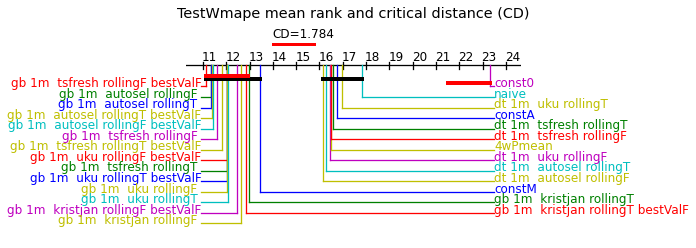

,testWmape: oracle,testWmape: constM,testWmape: gb 1m autosel rollingT bestValF,testWmape: gb 1m autosel rollingT,testWmape: gb 1m autosel rollingF,testWmape: gb 1m autosel rollingF bestValF,testWmape: gb 1m tsfresh rollingF bestValF,testWmape: gb 1m tsfresh rollingF,testWmape: gb 1m tsfresh rollingT bestValF,testWmape: gb 1m tsfresh rollingT,...,testWmape: gb 1m uku rollingF,testWmape: gb 1m uku rollingT bestValF,testWmape: gb 1m uku rollingT,testWmape: gb 1m kristjan rollingT bestValF,testWmape: gb 1m kristjan rollingT,testWmape: dt 1m autosel rollingF,testWmape: dt 1m uku rollingT,testWmape: dt 1m autosel rollingT,testWmape: dt 1m uku rollingF,testWmape: 4wPmean
mean,0.064695,0.607971,0.684681,0.686918,0.712656,0.716219,0.742797,0.748348,0.782038,0.784876,...,2.878519,6.048083,8.155501,9.549654,9.565191,11.803155,16.439564,21.333154,22.934749,25.996784
median,0.000000,0.577236,0.538753,0.535392,0.534734,0.531209,0.525204,0.531245,0.528689,0.535184,...,0.552717,0.552280,0.552280,0.566283,0.567198,0.618937,0.616960,0.606049,0.616960,0.616938


In [233]:
metric = 'testWmape'
plotCD(results[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,left=14,filename='_EE')
meanMedian[[metric+': '+i for i in algos]].sort_values(by='mean',axis=1)

Overall leader is GbTsfreshFF
- Regarding TestMAE, simplification is possible towards GbUku and constM (statistically the same as leader)
- Regarding TestR2, simplification is possible towards GbSel (statistically the same as leader)
- Regarding TestWmape, simplification is possible towards GbUku (statistically the same as leader)

In [20]:
eicBestRank

{'B7B6B96D8CA1E97B001C70C0C9AE7D59': 'gb 1m  tsfresh rollingF bestValF',
 'B7B6B96D8CA1E97B01740297BA64E433': 'gb 1m  uku rollingT bestValF',
 'B7B6B96D8CA1E97B03DB654FA70CE1B8': 'gb 1m  autosel rollingT ',
 'B7B6B96D8CA1E97B0A7628046D7E2ED3': 'constM',
 'B7B6B96D8CA1E97B16B47F51F58B6A6B': 'gb 1m  autosel rollingF bestValF',
 'B7B6B96D8CA1E97B224851B9682C286C': 'constA',
 'B7B6B96D8CA1E97B29890582FC608BA9': 'gb 1m  tsfresh rollingF bestValF',
 'B7B6B96D8CA1E97B2DE94BA83BE04DB9': 'gb 1m  autosel rollingF ',
 'B7B6B96D8CA1E97B308EC5153BD96044': 'constM',
 'B7B6B96D8CA1E97B4D51F3D61DFEA629': 'constM',
 'B7B6B96D8CA1E97B79C9F88B4BA82A59': 'gb 1m  tsfresh rollingF bestValF',
 'B7B6B96D8CA1E97B8551FBD1728BD900': 'gb 1m  autosel rollingT bestValF',
 'B7B6B96D8CA1E97B9B44F2A15EFF2DF7': 'gb 1m  autosel rollingT bestValF',
 'B7B6B96D8CA1E97B9D9DE3B0AC99E9CB': 'gb 1m  autosel rollingF ',
 'B7B6B96D8CA1E97BB86AAB5DEBE89493': 'const0',
 'B7B6B96D8CA1E97BC01543EF3267660A': 'gb 1m  uku rollingF ',
 '

In [21]:
eicF ={}
for i in eicBestRank:
    eicF[i] = af[eicBestRank[i]]
eicF

{'B7B6B96D8CA1E97B001C70C0C9AE7D59': 'results_GB20x30_TSFresh_rollingFalse_ValFalse.csv',
 'B7B6B96D8CA1E97B01740297BA64E433': 'results_GB20x30_uku_rollingTrue_ValFalse.csv',
 'B7B6B96D8CA1E97B03DB654FA70CE1B8': 'results_GB20x30_Sel_rollingTrue_ValTrue.csv',
 'B7B6B96D8CA1E97B0A7628046D7E2ED3': 'results_constM20x30.csv',
 'B7B6B96D8CA1E97B16B47F51F58B6A6B': 'results_GB20x30_Sel_rollingFalse_ValFalse.csv',
 'B7B6B96D8CA1E97B224851B9682C286C': 'results_constA20x30.csv',
 'B7B6B96D8CA1E97B29890582FC608BA9': 'results_GB20x30_TSFresh_rollingFalse_ValFalse.csv',
 'B7B6B96D8CA1E97B2DE94BA83BE04DB9': 'results_GB20x30_Sel_rollingFalse_ValTrue.csv',
 'B7B6B96D8CA1E97B308EC5153BD96044': 'results_constM20x30.csv',
 'B7B6B96D8CA1E97B4D51F3D61DFEA629': 'results_constM20x30.csv',
 'B7B6B96D8CA1E97B79C9F88B4BA82A59': 'results_GB20x30_TSFresh_rollingFalse_ValFalse.csv',
 'B7B6B96D8CA1E97B8551FBD1728BD900': 'results_GB20x30_Sel_rollingTrue_ValFalse.csv',
 'B7B6B96D8CA1E97B9B44F2A15EFF2DF7': 'results_GB2

In [75]:
eicFeature={}
for e in eicF:
    d = pd.read_csv(eicF[e])
    try: arr = d[d['eic']==e][['1topFeature','2topFeature','3topFeature']].values.flatten()
    except: arr = np.arange(5)
    eicFeature[e] = eicBestRank[e]+ ''.join(str(pd.DataFrame({'arr':arr})['arr'].value_counts().index.values[:5]))

In [76]:
eicFeature

{'B7B6B96D8CA1E97B001C70C0C9AE7D59': "gb 1m  tsfresh rollingF bestValF['t_12nh/12dhPstd' 'y-1d' 'y-24-7' 'y-24-1' 'y-24-3']",
 'B7B6B96D8CA1E97B01740297BA64E433': "gb 1m  uku rollingT bestValF['None' 't' 'hour']",
 'B7B6B96D8CA1E97B03DB654FA70CE1B8': "gb 1m  autosel rollingT ['y-1d' 'y-4w' 'hour_cos' 'y-24-1' 't_12nh/12dhFmin']",
 'B7B6B96D8CA1E97B0A7628046D7E2ED3': 'constM[0 1 2 3 4]',
 'B7B6B96D8CA1E97B16B47F51F58B6A6B': "gb 1m  autosel rollingF bestValF['y_4wPmin' 'y-1d' 'y-24_24hPstd' 'y-4w' 'p-9']",
 'B7B6B96D8CA1E97B224851B9682C286C': 'constA[0 1 2 3 4]',
 'B7B6B96D8CA1E97B29890582FC608BA9': "gb 1m  tsfresh rollingF bestValF['y-24-1' 'y-4w' 'y-4d' 'y-24-23' 'y_5wd/2wePmean']",
 'B7B6B96D8CA1E97B2DE94BA83BE04DB9': "gb 1m  autosel rollingF ['hour_sin' 'p-8' 'y-1d' 'y-7d' 'p+11']",
 'B7B6B96D8CA1E97B308EC5153BD96044': 'constM[0 1 2 3 4]',
 'B7B6B96D8CA1E97B4D51F3D61DFEA629': 'constM[0 1 2 3 4]',
 'B7B6B96D8CA1E97B79C9F88B4BA82A59': "gb 1m  tsfresh rollingF bestValF['y-1d' 'y-24-4' '